In [1]:
import torch
from fastai.basics import *
from fastai.vision.all import *
# from fastai.callback.tensorboard import TensorBoardCallback
from fastai.callback.tracker import SaveModelCallback

from pathlib import Path
import pandas as pd
import json

In [2]:
!pwd
!hostname

/home/m_zsuetam/uni/computational-intelligence/proj


AORUS-X470


In [3]:
ROOT_DIR = Path('.').resolve().parent
if ROOT_DIR.name != 'proj': # jupyter 
    ROOT_DIR = ROOT_DIR / 'proj'

DATASETS_DIR = ROOT_DIR / "datasets"
POTSDAM_DIR = DATASETS_DIR / "Potsdam-tiles-512"
assert POTSDAM_DIR.exists(), f"Potsdam dataset not found in {POTSDAM_DIR}"

EXPERIMENTS_DIR = ROOT_DIR / 'experiments'
LOGS_DIR = EXPERIMENTS_DIR / 'logs'
LOGS_DIR.mkdir(parents=True, exist_ok=True)

In [4]:
postdam_static = DATASETS_DIR/'Potsdam-static'
df_classes = pd.read_csv(postdam_static/'classes.csv')
df_classes

,class_id,name,color_name,color
0,0,Impervious surfaces,white,"(255, 255, 255)"
1,1,Buildings,blue,"(0, 0, 255)"
2,2,Low vegetation,cyan,"(0, 255, 255)"
3,3,Trees,green,"(0, 255, 0)"
4,4,Cars,yellow,"(255, 255, 0)"
5,5,Clutter,red,"(255, 0, 0)"
6,6,Undefined,black,"(0, 0, 0)"


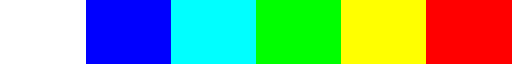

In [5]:
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.colors import ListedColormap

def hex2rgb(hex_color):
    if isinstance(hex_color, tuple) or isinstance(hex_color, list):
        return tuple(hex_color)
    if hex_color.startswith('#'):
        hex_color = hex_color.lstrip('#')
        t = tuple(int(hex_color[i:i+2], 16) for i in (0, 2, 4))
    else:
        t = tuple(int(x.strip()) for x in hex_color.strip('()').split(','))
    return t

ssd_cmap = ListedColormap(
    df_classes['color'].apply(lambda x: np.array(hex2rgb(x))/255.0).to_list(),
    name='skyscapes',
    N = len(df_classes) -1
) 

potsdam_plot_kwargs = {
    'vmin': 0,
    'vmax': len(df_classes) - 1 - 1,
    'cmap': ssd_cmap
}

potsdam_legend_kwargs = {
    'handles': [
        Patch(color=potsdam_plot_kwargs['cmap'](i), label=name) 
        for i, name in enumerate(df_classes[:-1].name.values)
    ],
    'bbox_to_anchor': (1.05, 1),
    'loc': 'upper left',
    'borderaxespad': 0.,
}

potsdam_plot_kwargs['cmap']

In [6]:
pixel_accuracy = partial(accuracy, axis=1)

metrics = [
    pixel_accuracy,
    
    DiceMulti(), # F1 Score

    JaccardCoeffMulti(), # IoU
]

In [7]:
def get_valid_images(ds):
    if ds == 'new-ds':
        image_paths = L(sorted([f for f in get_image_files(POTSDAM_DIR) if f.parent != 'labels']))
        valid_image_paths = L([f for f in image_paths if f.parent.parent.name == 'val'])
        return valid_image_paths

    raise ValueError(f'Unknown dataset: {ds}')

In [8]:
BATCH_SIZE = 8

# Interpretation

In [9]:
from fastai.callback.tensorboard import TensorBoardCallback

2026-01-13 21:03:30.141374: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2026-01-13 21:03:30.141468: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2026-01-13 21:03:30.170311: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2026-01-13 21:03:30.230093: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.

A module that was compiled using NumPy 1.x cannot be

AttributeError: _ARRAY_API not found


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.2.6 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/home/m_zsuetam/anaconda3/envs/dl/lib/python3.11/site-packages/ipykernel_launcher.py", line 17, in <module>
    app.launch_new_instance()
  File "/home/m_zsuetam/.local/lib/python3.11/site-packages/traitlets/config/application.py", line 1075, in launch_instance
    app.start()
  File "/home/m_zsuetam/anaconda3/envs/dl/lib/python3.11/site-packages/ipykernel/kernelapp.py", line 701, in start
    self.io_loop.start

AttributeError: _ARRAY_API not found


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.2.6 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/home/m_zsuetam/anaconda3/envs/dl/lib/python3.11/site-packages/ipykernel_launcher.py", line 17, in <module>
    app.launch_new_instance()
  File "/home/m_zsuetam/.local/lib/python3.11/site-packages/traitlets/config/application.py", line 1075, in launch_instance
    app.start()
  File "/home/m_zsuetam/anaconda3/envs/dl/lib/python3.11/site-packages/ipykernel/kernelapp.py", line 701, in start
    self.io_loop.start

AttributeError: _ARRAY_API not found

ImportError: numpy.core._multiarray_umath failed to import

In [10]:
def get_validation_dict(learn):

    results = learn.validate()
    
    metrics = ['valid_loss'] + [m.name for m in learn.metrics]
    
    validation_dict = {}
    for metric_name, metric_value in zip(metrics, results):
        validation_dict[metric_name] = metric_value
    
    return validation_dict

In [11]:
def calculate_cm(learn):
    "Calculate confusion matrix on validation set"
    preds, targs = learn.get_preds(ds_idx=1)
    preds = preds.argmax(dim=1).view(-1)
    targs = targs.view(-1)
    n_classes = df_classes.shape[0]
    cm = torch.zeros((n_classes, n_classes), dtype=torch.int64)
    for p, t in zip(preds, targs):
        cm[t, p] += 1
    return cm

In [12]:
all_models = sorted(list(EXPERIMENTS_DIR.rglob('*.pkl')))
all_models = [p for p in all_models if p.parents[1].name == 'new-ds']
all_models

[Path('/home/m_zsuetam/Documents/Uni/computational-intelligence/proj/experiments/new-ds/baseline_34/baseline_34.pkl'),
 Path('/home/m_zsuetam/Documents/Uni/computational-intelligence/proj/experiments/new-ds/baseline_34_pretrained/baseline_34_pretrained.pkl'),
 Path('/home/m_zsuetam/Documents/Uni/computational-intelligence/proj/experiments/new-ds/cse/cse.pkl'),
 Path('/home/m_zsuetam/Documents/Uni/computational-intelligence/proj/experiments/new-ds/cse_combined_loss/cse_combined_loss.pkl'),
 Path('/home/m_zsuetam/Documents/Uni/computational-intelligence/proj/experiments/new-ds/cse_phase_2/cse_phase_2.pkl'),
 Path('/home/m_zsuetam/Documents/Uni/computational-intelligence/proj/experiments/new-ds/cse_phase_3/cse_phase_3.pkl')]

In [13]:
import seaborn as sn
def plot_cm(experiment_dict, normalize=True, out_dir=Path('.')):
    cm = np.array(experiment_dict['confusion_matrix'])
    # Remove the last class (last row and column)
    cm = cm[:-1, :-1]
    class_names = df_classes['name'][:-1]

    df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
    if normalize:
        df_cm = df_cm.div(df_cm.sum(axis=1), axis=0)
    plt.figure(figsize=(10, 7))
    sn.heatmap(df_cm, annot=True)
    plt.savefig(out_dir / 'confusion_matrix.png')

In [14]:
def plot_target_predictions(experiment_dict, out_dir=Path('.')):
    indices = experiment_dict['examples']['indices']
    paths = experiment_dict['examples']['paths']
    predictions = experiment_dict['examples']['predictions']
    targets = experiment_dict['examples']['targets']
    
    n_examples = len(indices)
    fig, axs = plt.subplots(n_examples, 3, figsize=(12, 4 * n_examples))
    
    for i in range(n_examples):
        img_path = Path(paths[i])
        img = PILImage.create(img_path)
        axs[i, 0].imshow(img)
        axs[i, 0].set_title(f'Image: {img_path.name}')
        axs[i, 0].axis('off')
        
        axs[i, 1].imshow(img)
        axs[i, 1].imshow(np.array(targets[i]), **potsdam_plot_kwargs, alpha=0.5)
        axs[i, 1].set_title('Ground Truth')
        axs[i, 1].axis('off')
        
        axs[i, 2].imshow(img)
        axs[i, 2].imshow(np.array(predictions[i]), **potsdam_plot_kwargs, alpha=0.5)
        axs[i, 2].set_title('Prediction')
        axs[i, 2].axis('off')
    axs[1, 2].legend(**potsdam_legend_kwargs)
    
    plt.tight_layout()
    plt.savefig(out_dir / f'pred-targets.png')

In [ ]:
from tqdm import tqdm

results_summary = {}
for m in tqdm(all_models):
    model_entry_dict = {}
    model_name = m.stem
    experiment_name = m.parent.name
    dataset_codename = m.parent.parent.name
    model_entry_dict['experiment'] = experiment_name
    model_entry_dict['dataset'] = dataset_codename
    model_entry_dict['pretrained'] = 'pretrained' in model_name.lower()

    print(f'Loading model: {model_name} from {experiment_name} on {dataset_codename} dataset')

    learn: Learner = load_learner(m, cpu=False)
    learn.remove_cbs([cb for cb in learn.cbs if isinstance(cb, TensorBoardCallback)])
    
    model_entry_dict['loss_function'] = learn.loss_func.__class__.__name__
    model_entry_dict['params'] = sum(p.numel() for p in learn.model.parameters())

    valid_files = get_valid_images(dataset_codename)
    dl = learn.dls.test_dl(valid_files, with_labels=True, bs=BATCH_SIZE)
    dl.to(learn.dls.device)
    learn.dls.valid = dl
    
    with learn.no_bar(), learn.no_logging():
        val_dict = get_validation_dict(learn)
    model_entry_dict['validation'] = val_dict

    dl = learn.dls.test_dl(valid_files[range(0, len(valid_files), len(valid_files)//10)], with_labels=True, bs=BATCH_SIZE)
    dl.to(learn.dls.device)
    learn.dls.valid = dl
    
    with learn.no_bar(), learn.no_logging():
        cm = calculate_cm(learn)
    model_entry_dict['confusion_matrix'] = cm.tolist()
    plot_cm(model_entry_dict, out_dir=m.parent)

    idxs_to_check = [20, 226, 336] 
    safe_idxs = [i for i in idxs_to_check if i < len(valid_files)]
    subset_files = [valid_files[i] for i in safe_idxs]

    if subset_files:
        mini_dl = learn.dls.test_dl(subset_files, with_labels=True)
        x, y = mini_dl.one_batch()

        preds, targs, dec_preds = learn.get_preds(dl=mini_dl, with_decoded=True)
        decoded_batch = mini_dl.decode_batch((x, y), max_n=len(subset_files))
        
        model_entry_dict['examples'] = {
            'indices': safe_idxs,
            'paths': [str(p) for p in subset_files], # Very useful to keep the path!
            'predictions': dec_preds.tolist(),
            'targets': targs.tolist(),
        }

        plot_target_predictions(model_entry_dict, out_dir=m.parent)

    results_summary[model_name] = model_entry_dict

# results_summary

[0 1 2 3 5] (512, 512)


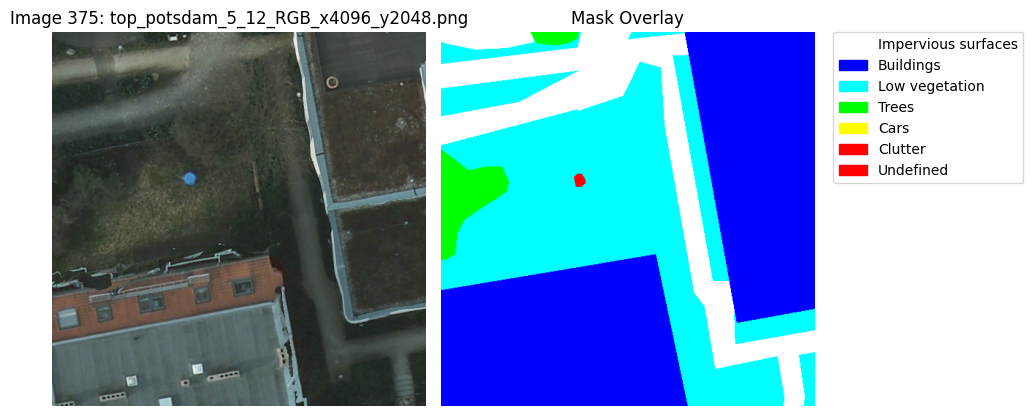

In [ ]:
# random_idx = torch.randint(0, len(valid_files), (1,)).item()
# img = PILImage.create(valid_files[random_idx])
# masked_img = PILImage.create(valid_files[random_idx].parent.parent/'labels'/valid_files[random_idx].name.replace('_RGB', '_label'), mode='L')
# mask = np.array(masked_img)

# fig, axs = plt.subplots(1, 2, figsize=(10, 5))
# axs[0].imshow(img)
# axs[0].set_title(f'Image {random_idx}: {valid_files[random_idx].name}')
# axs[0].axis('off')

# # axs[1].imshow(img)
# print(np.unique(mask), mask.shape)
# axs[1].imshow(mask, **potsdam_plot_kwargs)
# axs[1].set_title('Mask Overlay')
# axs[1].axis('off')
# plt.legend(**potsdam_legend_kwargs)

# plt.tight_layout()
# plt.show()

In [110]:
import seaborn as sns

metrics_df = pd.DataFrame({
    model: {k: round(v, 2) for k, v in entry['validation'].items() if k not in ['valid_loss', 'masked_jaccard_coeff_multi']}
    for model, entry in results_summary.items() 
}).T
metrics_df.index.name = "model"
metrics_df = metrics_df.sort_index()
metrics_df
# Filter out 'baseline_34_pretrained'
filtered_df = metrics_df[~metrics_df.index.str.contains('baseline_34_pretrained')]

# Display as a styled table instead of a heatmap
styled_df = filtered_df.style.set_caption("Model Metrics Table").format(precision=2).background_gradient(cmap="magma", axis=None)
# Save the styled DataFrame to an HTML file
styled_df.to_html("experiments/new-ds/model_metrics_table.html")
display(styled_df)


,accuracy,dice_multi,jaccard_coeff_multi
model,,,
baseline_34,0.83,0.75,0.63
cse,0.85,0.75,0.63
cse_combined_loss,0.77,0.66,0.54
cse_phase_2,0.87,0.78,0.67
cse_phase_3,0.86,0.76,0.65


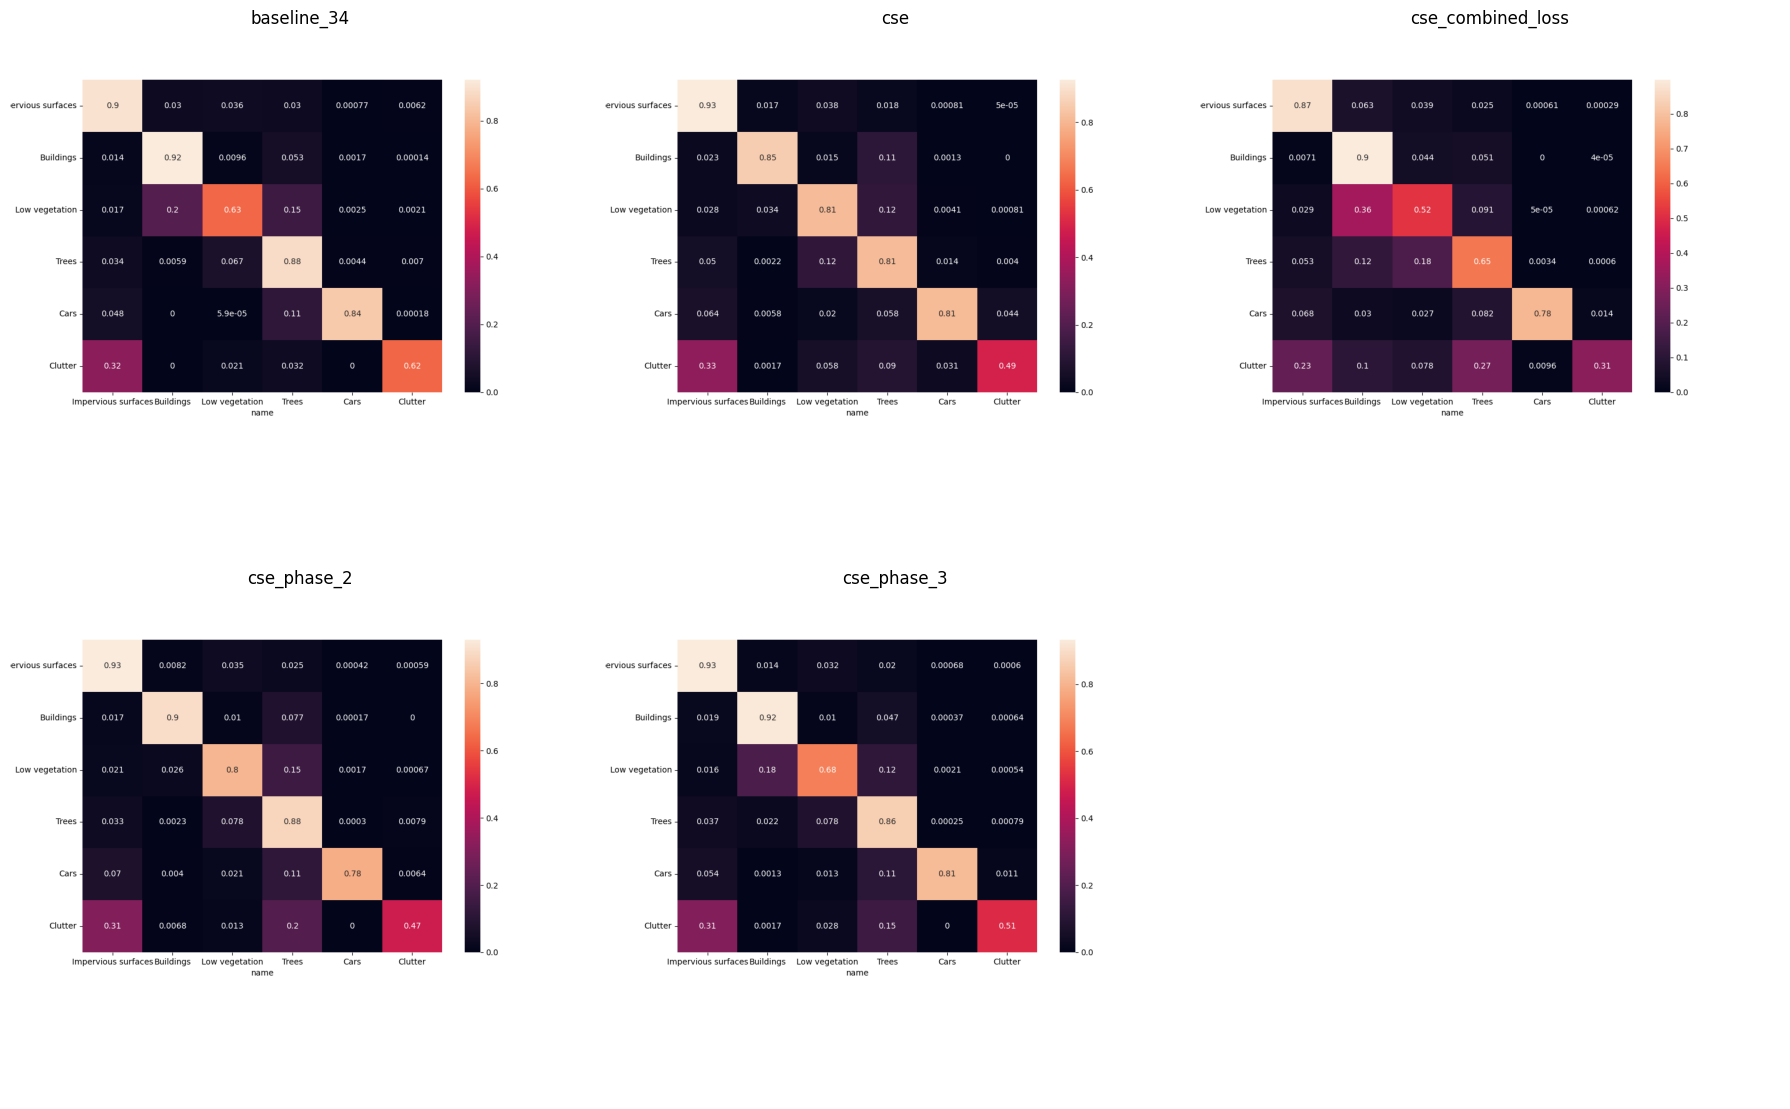

In [108]:
fig, axs = plt.subplots(2, int(np.ceil(len(filtered_df)/2)), figsize=(6 * int(np.ceil(len(filtered_df)/2)), 12))
axs = axs.flatten()

for ax, model in zip(axs, filtered_df.index):
    cm_path = EXPERIMENTS_DIR / 'new-ds' / model / 'confusion_matrix.png'
    img = plt.imread(cm_path)
    ax.imshow(img)
    ax.set_title(model)
    ax.axis('off')
axs[-1].axis('off')

plt.tight_layout()
plt.show()

In [16]:
learn = load_learner(EXPERIMENTS_DIR / 'new-ds' / 'cse_phase_2' / 'cse_phase_2.pkl', cpu=False)

In [31]:
valid_files = get_valid_images('new-ds')

# [:int(0.25*len(valid_files))]
dl = learn.dls.test_dl(valid_files, with_labels=True)
dl.to(learn.dls.device)
learn.dls.valid = dl

In [32]:
import notebooks.utils.segmentation_interpretation as segm_utils
import importlib
importlib.reload(segm_utils)
from notebooks.utils.segmentation_interpretation import MySegmentationInterpretation

# preds, targs = learn.tta()
# preds, targs, losses = learn.get_preds(dl=learn.dls.valid, with_loss=True)
preds, targs = learn.get_preds(dl=dl)

: 

: 

: 

In [19]:
interp = MySegmentationInterpretation(
    learn,
    learn.dls.valid,
    preds,
    targs,
    torch.tensor([0 for _ in range(len(targs))]),
    lambda x: torch.tensor(x),
    df_classes=df_classes.rename(columns={'class_id': 'class', 'name':'category'}).iloc[:-1]
)

In [ ]:
interp.stats_per_class()

In [ ]:
interp.plot_df_result_classes()